In [1]:
%load_ext autoreload
%autoreload 2

In [93]:
import random
import numpy as np
import pyaml

import cupy
import chainer
import chainer.links as L
import chainer.functions as F

from chainer_addons.training.extensions.progress_bar import JupyterProgressBar

from dataclasses import dataclass
from matplotlib import pyplot as plt
from matplotlib import colors
from tabulate import tabulate

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils._testing import  ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.mixture import GaussianMixture as GMM

from fve_layer.backends.chainer.links import FVELayer
from fve_layer.backends.chainer.links import FVELayer_noEM
from fve_layer.common.visualization import draw_ellipse

In [3]:
@dataclass
class Args:
    def __str__(self):
        return pyaml.dump(dict(Arguments=self.__dict__), sort_dicts=False)

    n_dims:                int = 2
    n_samples:             int = 128
    n_classes:             int = 4
    sample_std:            float = 1
        
    data_scale:            float = 10
    data_shift:            np.ndarray = np.array([5,5])
    
    n_components:          int = 1
    
    fve_linear:            bool = False
    fve_only_mu:           bool = True
    fve_only_sig:          bool = False
    fve_normalize:         bool = True
    fve_no_update:         bool = False
        
    batch_size:            int = 32
    learning_rate:         float = 1e-2
    seed:                  float = 42
    device:                int = -1
    
args = Args()

print(args)

Arguments:
  n_dims: 2
  n_samples: 128
  n_classes: 4
  sample_std: 1
  data_scale: 10
  data_shift:
    - 5
    - 5
  n_components: 1
  fve_linear: false
  fve_only_mu: true
  fve_only_sig: false
  fve_normalize: true
  fve_no_update: false
  batch_size: 32
  learning_rate: 0.01
  seed: 42
  device: -1



In [4]:
def concat_var_examples(batch, device=None):
    
    Xs, ys = zip(*batch)
    
    Xs = F.stack(Xs, axis=0)
    ys = np.hstack(ys)
    return Xs, ys

def _get_array(var):
    return getattr(var, "array", var)

def _new_data(n_samples, n_dims, mean, std, rnd=None):
    """ generates normal distributed data """
    rnd = rnd or np.random.RandomState()
    return rnd.normal(loc=mean, scale=std, size=(n_samples, n_dims))

def _new_data2(n_samples, n_dims, mean, std, rnd=None, *, n_circles=4):
    """ generates data as regular circles """
    assert n_dims == 2, "Only 2-D data is supported"
    
    factors = np.linspace(0.5, 2, num=n_circles) # eg. default is [0.5, 1.0, 1.5, 2.0]
    # in each row is one of the factors multiplied with the std    
    _stds = np.outer(factors, std) 
    _n_samples = n_samples // n_circles
    
    _X = np.zeros((n_samples, n_dims), dtype=mean.dtype)
    
    for i, _std in enumerate(_stds):
        # distribute the samples in a circle
        angles = np.linspace(0, 2*np.pi, _n_samples, endpoint=False)
        xs = np.vstack([np.cos(angles), np.sin(angles)]).T
        
        i0 = i * _n_samples
        i1 = i0 + _n_samples
        _X[i0:i1] = xs * _std + mean
    
    return _X

def _new_rnd(seed, is_evaluation):
    if seed is not None and is_evaluation:
        seed = 2**31 - seed
        
    return np.random.RandomState(seed)

class Data(chainer.dataset.DatasetMixin):
    @classmethod
    def new(cls, args: Args, evaluation: bool=False):
        return cls(
            n_classes=args.n_classes,
            n_dims=args.n_dims,
            n_samples=args.n_samples,
            std=args.sample_std,
            scale=args.data_scale,
            shift=args.data_shift,
            rnd=_new_rnd(args.seed, evaluation)
        )
    
    def __init__(self, *, n_classes, n_dims, n_samples, std=1, dtype=np.float32, scale=None, shift=None, rnd=None):
        super(Data, self).__init__()
        
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dims = n_dims
        
        self.X = np.zeros((n_classes * n_samples, n_dims), dtype=dtype)
        self.y = np.zeros(n_classes * n_samples, dtype=np.int32)
        
        # distribute the class centers evenly in a circle (in the 1st two dimensions)
        _comp_pos = np.linspace(0, 2*np.pi, n_classes, endpoint=False)
        self._means = np.zeros((n_classes, n_dims), dtype=np.float32)
        self._means[:, :2] = np.vstack([np.cos(_comp_pos), np.sin(_comp_pos)]).T
        
        self._std = np.ones(n_dims, dtype=np.float32) / n_classes * std
        

        for i, mean in enumerate(self._means):
            _X = _new_data(n_samples, n_dims, mean, self._std, rnd)
#             _X = _new_data2(n_samples, mean, self._std, rnd)
            n0 = i * self.n_samples
            n1 = n0 + self.n_samples
            self.X[n0: n1] = _X
            self.y[n0: n1] = i
        
        if scale is not None:
            self.X *= scale
            self._means *= scale
            self._std *= scale
            
        if shift is not None:
            self.X += shift
            self._means += shift
        
        self.X = chainer.Variable(self.X, name="data")
        
    def __len__(self):
        return len(self.y)

    def get_example(self, i):
        return self.X[i], self.y[i]

    def plot(self, 
             ax: plt.Axes = None, 
             cm: colors.ListedColormap = None,
             marker: str = None,
             alpha: float = 1.0,
             plot_grad=False,
             **kwargs,
            ):
        
        ax = ax or plt.gca()
        cm = cm or plt.cm.viridis
        _x = chainer.cuda.to_cpu(_get_array(self.X))
        _y = chainer.cuda.to_cpu(self.y)
        ax.scatter(*_x.T, c=cm(_y / self.n_classes), marker=marker, alpha=alpha)
        if plot_grad and self.X.grad is not None:
            self._plot_grads(ax, cm, **kwargs)
        return ax
    
    
    def _plot_grads(self, 
                    ax: plt.Axes, 
                    cm: colors.ListedColormap, 
                    norm: bool = True, 
                    xp=np):
        
        x0 = self.X.array
        step_size = 1e-1
        
        grad = self.X.grad.copy()
        if norm:
            grad_norm = xp.sqrt(xp.sum(grad **2, axis=1))
            mask = grad_norm != 0
            grad[mask] = grad[mask] / grad_norm[mask, None]
        
        for (x, y), (dx, dy), lab in zip(x0, -grad, self.y):
            if dx == dy == 0: 
                continue
            ax.arrow(x,y, dx, dy, width=2e-1, facecolor=cm(lab / self.n_classes))
        
        return ax

In [5]:
class Classifier(chainer.Chain):
    
    @classmethod
    def new(cls, opts: Args, *a, **kw):
        args, kwargs = cls.extract_args(opts, *a, **kw)
        return cls(*args, **kwargs)
    
    @classmethod
    def extract_args(cls, opts: Args, *a, **kw):
        args = tuple(a)
        kwargs = dict(kw,
            n_classes=opts.n_classes,
            in_size=opts.n_dims,
        )
        return args, kwargs

    def report(self, **values):
        chainer.report(values, self)        
        
    def __init__(self, n_classes, in_size=2):
        super(Classifier, self).__init__()
        self.n_classes = n_classes
        with self.init_scope():
            self.fc = L.Linear(in_size=in_size, out_size=n_classes)
        
    def decision_function(self, X):
        features = self.encode(X)
        return self.classify(features)
        
    def encode(self, X):
        return X
    
    def classify(self, features):
        #return self.fc(F.dropout(features))
        return self.fc(features)

    def forward(self, X, y=None):
        logits = self.decision_function(X)
        
        accu, loss = F.accuracy(logits, y), F.softmax_cross_entropy(logits, y)
        
        self.report(accu=accu, loss=loss)
        
        # uncomment this to plot gradients of the FVE w.r.t. the inputs only
        #return F.sum(features)
        
        # returning the classification loss, plots the gradients of the classification
        # w.r.t. the inputs (composed of the FVE gradient and classifier gradient)
        return loss
    
    def plot(self, ax: plt.Axes = None, cm: colors.ListedColormap = None):
        ax = ax or plt.gca()
        cm = cm or plt.cm.viridis
                
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        xs = np.array(xlim)
        
        tri = np.tri(self.n_classes, self.n_classes, -1, dtype=np.bool)
        i0s, i1s = np.where(tri)
        
        W, bias = self.fc.W.array, self.fc.b.array
        for i0, i1 in zip(i0s, i1s):
            w0x, w0y = W[i0]
            b0 = bias[i0]
            
            w1x, w1y = W[i1]
            b1 = bias[i1]

            a, b  = -(w0x-w1x) / (w0y-w1y), -(b0-b1) / (w0y-w1y)

            ys = a * xs + b

            ax.plot(xs, ys, c="k")
                
            
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        return ax
        

In [38]:
class FVEClassifier(Classifier):
    
    @classmethod
    def extract_args(cls, opts: Args, *a, **kw):
        args, kwargs = super(FVEClassifier, cls).extract_args(opts, *a, **kw)
        
        n_comps = opts.n_components if opts.n_components > 0 else opts.n_classes
        kwargs = dict(kwargs,
                      in_size=opts.n_dims,
                      n_components=n_comps,
                      normalize=opts.fve_normalize,
                      only_mu=opts.fve_only_mu,
                      only_sig=opts.fve_only_sig,
                      linear_clf=opts.fve_linear,
                      no_update=opts.fve_no_update,
                     )
        
        return args, kwargs
    def __init__(self, n_classes, in_size=2, *, 
                 n_components=1, fve_class=FVELayer, 
                 linear_clf=False,
                 normalize=False,
                 only_mu=False,
                 only_sig=False,
                 no_update=False,
                 **kwargs):
        
        factor = 1 if (only_mu or only_sig) else 2
        encoding_size = factor * in_size * n_components

        super(FVEClassifier, self).__init__(n_classes, in_size=encoding_size)

        with self.init_scope():
            self.fve_layer = fve_class(in_size=in_size, n_components=n_components, **kwargs)
            if linear_clf:
                post_fve = None
            else:
                post_fve = L.Linear(in_size=encoding_size, out_size=encoding_size)
            self.post_fve = post_fve
            
            self.add_persistent("is_linear", linear_clf)
            self.add_persistent("normalize", normalize)
            self.add_persistent("only_mu", only_mu)
            self.add_persistent("only_sig", only_sig)
            self.add_persistent("no_update", no_update)

        
    def encode(self, X):
        x = F.expand_dims(X, axis=1)
        
        if self.no_update:
            with chainer.using_config("train", False), chainer.no_backprop_mode():
                enc = self.fve_layer(x)

        else:
            enc = self.fve_layer(x)

        dist = self.fve_layer.mahalanobis_dist(x)
        assingment = self.fve_layer.soft_assignment(x)
        mean_dist = F.mean(F.sum(assingment * dist, axis=-1))
        self.report(dist=mean_dist)
        
        
        if self.normalize:
            enc = F.normalize(enc)
                
        _, size = enc.shape

        if self.only_mu and self.only_sig:
            raise ValueError("Setting both only_mu and only_sig is not allowed!")
            
        elif self.only_mu and not self.only_sig:
            enc = enc[:, :size//2]

        elif not self.only_mu and self.only_sig:
            enc = enc[:, size//2:]

        return enc
    
    def classify(self, features):
        if self.post_fve is not None:
            features = F.relu(self.post_fve(features))
            
        elif not self.is_linear:
            features = F.relu(features)
            
        return super(FVEClassifier, self).classify(features)  
        
    
    def plot(self, ax: plt.Axes = None, cm: colors.ListedColormap = None):
        if self.fve_layer.in_size != 2: return
        
        mu = _get_array(self.fve_layer.mu)
        sig = _get_array(self.fve_layer.sig)
        
        for _mu, _sig in zip(mu.T, sig.T):
            ax.scatter(*_mu, marker="x", color="black")
            draw_ellipse(_mu, _sig, nsig=2, ax=ax, alpha=0.3)
            
        
        return ax
        

In [39]:
def set_seed(seed=None):
    np.random.seed(seed)
    cupy.random.seed(seed)
    random.seed(seed)


def zero_grads(stop_trigger):
    enabled = stop_trigger[1] == "epoch"
    
    @chainer.training.extension.make_extension(trigger=(1, "epoch"))
    def inner(trainer):
        if not enabled:
            return 
        
        updater = trainer.updater
        if updater.epoch == stop_trigger[0]:
            return 
        
        data = updater.get_iterator("main").dataset

        data.X.cleargrad()

    return inner


In [40]:
def _plot_decisions(X, y, clf, ax=None, resolution=0.01, alpha=0.5):
    if X.shape[1] != 2:
        return 
    
    ax = ax or plt.gca()

    X, y = data.X.array, data.y

    # create the grid for background colors
    x_min, x_max = X[:, 0].min() , X[:, 0].max() 
    y_min, y_max = X[:, 1].min() , X[:, 1].max() 
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max*(1 + resolution), resolution*(x_max-x_min)), 
        np.arange(y_min, y_max*(1 + resolution), resolution*(y_max-y_min))
    )

    # plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]*[y_min, y_max].
    _X = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    if hasattr(clf, "decision_function"):
        decision = clf.decision_function(_X)
        Z = getattr(decision, "array", decision).argmax(axis=1)
    else:
        Z = clf.predict_proba(_X)[:, 1]

    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=alpha)

In [41]:
def _plot_params(data: Data, clf: FVEClassifier, 
                 clf_dump: FVEClassifier = None, 
                 eval_data: Data = None,
                 title: str = None, 
                 plot_grad: bool = False,
                 plot_norm_grad: bool = False,
                 fig_axs=None):
    
    
    if fig_axs is None:
        if clf_dump is None:
            ax0 = None
            fig, ax1 = plt.subplots(figsize=(12,12))
            
        else:
            fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,9))
            ax0.set_title("Before Training")
            ax1.set_title("After Training")

    else:
        fig, axs = fig_axs
        try:
            ax0, ax1 = axs
        except:
            ax0, ax1 = None, axs
            

    if title is not None:
        fig.suptitle(title)
    
    if ax0 is not None:
        data.plot(ax=ax0)
        if eval_data is not None:
            eval_data.plot(ax=ax0, marker="x", alpha=0.5)
        clf_dump.plot(ax=ax0)

    data.plot(ax=ax1, plot_grad=plot_grad, norm=plot_norm_grad)
    if eval_data is not None:
        eval_data.plot(ax=ax1, marker="x", alpha=0.5)
    clf.plot(ax=ax1)

    return fig, (ax0, ax1)

In [42]:
@ignore_warnings(category=ConvergenceWarning)
def baseline(data, eval_data=None, clf_class=LinearSVC):
    
    X, y = data.X.array, data.y
    X_val, y_val = None, None
    
    if eval_data is not None:
        X_val, y_val = eval_data.X, eval_data.y
    
    svm = clf_class()

    searcher = GridSearchCV(svm,
        n_jobs=4, param_grid=dict(
            C=[1e-2, 1e-1, 1e0, 1e1, 1e2],
            tol=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
        )).fit(X, y)
    
    kwargs = searcher.best_params_
    svm = clf_class(**kwargs).fit(X, y)
    
    print(f"Baseline ({clf_class.__name__}) with best params ({kwargs})")
    accu = svm.score(X, y)
    print(f"Training accu:   {accu: 10.2%}")
    if eval_data is not None:
        val_accu = svm.score(X_val, y_val)
        print(f"Validation accu: {val_accu: 10.2%}")
        
    if X.shape[1] != 2: 
        return
    
    fig, ax = plt.subplots(figsize=(12,12))
    _plot_decisions(X, y, clf=svm, alpha=0.5, ax=ax)
        
    # plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', alpha=0.7)

    if eval_data is not None:
        ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, marker="x", edgecolors='k', alpha=0.7)
    
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax.grid()
    
    
    plt.show()
    plt.close()


In [44]:
def analyze_classifier(args: Args, data: Data, clf: Classifier, 
                       triggers: dict, 
                       eval_data: Data = None,
                       print_params: bool = False,
                       plot_params: bool = True,
                       plot_decisions: bool = False,
                       title: str = None):
    print(clf)
    if data.X.shape[1] == 2:
        clf_dump = clf.copy(mode="copy")
    
    
    device = chainer.cuda.get_device_from_id(args.device)
    device.use()
    clf.to_device(device)
    
    data.X.to_device(device)
    data.y = chainer.cuda.to_gpu(data.y)
    
    train(data, clf, 
          batch_size=args.batch_size,
          learning_rate=args.learning_rate,
          device=args.device,
          triggers=triggers,
          eval_data=eval_data)
    
    clf.to_cpu()
    data.X.to_cpu()
    data.y = chainer.cuda.to_cpu(data.y)
    
    if data.X.shape[1] != 2: return
            
    if plot_params:
        
        fig, (ax0, ax1) = _plot_params(data, clf, 
                                       eval_data=eval_data,
                                       clf_dump=clf_dump, 
                                       title=title)
    
    else:
        ax0 = None
        fig, ax1 = plt.subplots(figsize=(12,12))
        data.plot(ax1)
        if eval_data is not None:
            eval_data.plot(ax1, marker="x", alpha=0.5)
        
    if plot_decisions:
        X, y = data.X.array, data.y
        with chainer.using_config("train", False):
            #_plot_decisions(X, y, clf=clf_dump, alpha=0.3, ax=ax0)
            _plot_decisions(X, y, clf=clf, alpha=0.3, ax=ax1)

    plt.show()
    plt.close()
    
    if print_params:
        fmt = "({0: 10.3f}, {1: 10.3f})"

        if args.n_components == 1:
            _x = _get_array(data.X)
            print("=== Data stats ===")
            print(tabulate([(fmt.format(*_x.mean(axis=0)), fmt.format(*_x.var(axis=0)))], 
                           headers=["\u03BC", "\u03C3"], 
                           tablefmt="fancy_grid",
                          )
                 )
            print()

        for i, c in enumerate([clf_dump, clf]):
            rows = []

            for _mu, _sig in zip(_get_array(c.fve_layer.mu).T, _get_array(c.fve_layer.sig).T):
                rows.append([fmt.format(*_mu), fmt.format(*_sig)])

            print("=== Estimated GMM Parameters ===" if i == 1 else "=== Initial GMM Parameters ===")
            print(tabulate(rows, 
                           headers=["\u03BC", "\u03C3"], 
                           tablefmt="fancy_grid",
                           showindex=True,
                          )
                 )
            print()
            

In [45]:
def analyze_gradient(args: Args, data: Data, clf: Classifier, 
                     triggers: dict,
                     eval_data: Data = None,
                     plot_params: bool = True,
                     plot_decisions: bool = False,
                     title: str = None,
                     **kwargs,
                    ):
    print(clf)
    
    train(data, clf, 
          batch_size=args.batch_size,
          learning_rate=args.learning_rate,
          triggers=triggers,
          eval_data=eval_data)
    
    if data.X.shape[1] != 2: return
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,9))
    
    feat = clf.encode(data.X)
    feat.grad = clf.xp.ones_like(feat.array)
    feat.backward()
    
    ax0.set_title("Gradient of the encoding wrt input")
    _plot_params(data, clf, 
                 eval_data=eval_data,
                 plot_grad=True, 
                 fig_axs=(fig, ax0),
                 **kwargs)
    
    
    
    data.X.grad = None
    feat.grad = None
    pred = clf.classify(feat)
    loss = F.softmax_cross_entropy(pred, data.y)
    loss.backward()
    
    ax1.set_title("Gradient of loss wrt input")
    _plot_params(data, clf, 
                 eval_data=eval_data,
                 plot_grad=True, 
                 fig_axs=(fig, ax1),
                 **kwargs)

    if plot_decisions:
        X, y = data.X.array, data.y
        with chainer.using_config("train", False):
            _plot_decisions(X, y, clf=clf, alpha=0.3, ax=ax1)

    plt.show()
    plt.close()

In [46]:
# small setup
D = 2
N = 64

# medium setup
# D = 3
# N = 32*D

# # big setup
# D = 512
# N = 512

args = Args(
    n_dims=D,
    n_classes=5,
    n_samples=N, 
    
    sample_std=1.5, 
    data_shift=None,#np.full(D, fill_value=0, dtype=np.float32),
    data_scale=10,
    
    batch_size=N*5,
    learning_rate=1e-1,
    
    n_components=5,
    
    fve_only_mu=False,
    fve_only_sig=False,
    fve_normalize=False,
    
    fve_linear=False,
    fve_no_update=False,
    
    seed=42,
    device=0,
)
print(args)


Arguments:
  n_dims: 2
  n_samples: 64
  n_classes: 5
  sample_std: 1.5
  data_scale: 10
  data_shift:
  n_components: 5
  fve_linear: false
  fve_only_mu: false
  fve_only_sig: false
  fve_normalize: false
  fve_no_update: false
  batch_size: 320
  learning_rate: 0.1
  seed: 42
  device: 0



In [47]:
data = Data.new(args)
eval_data = Data.new(args, evaluation=True)
if eval_data is not None:
    eval_data.X = eval_data.X.array

Baseline (LinearSVC) with best params ({'C': 0.01, 'tol': 0.01})
Training accu:       97.19%
Validation accu:     95.62%


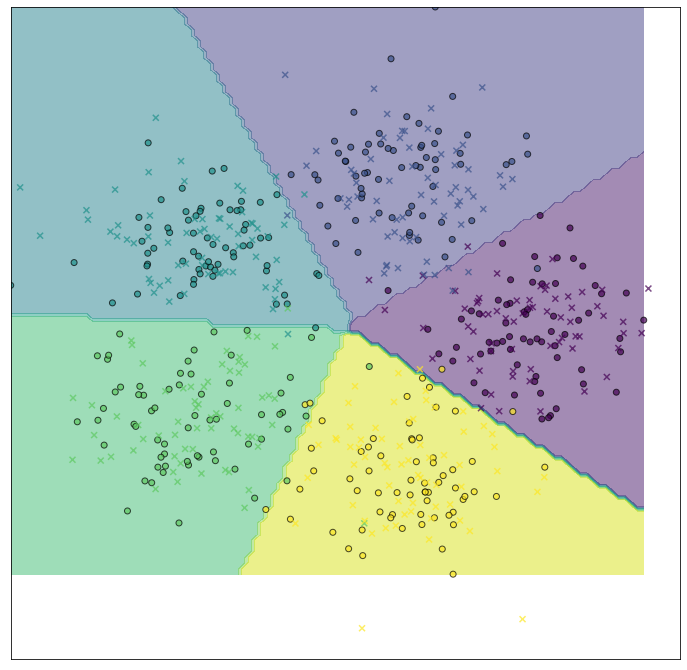

CPU times: user 164 ms, sys: 64 ms, total: 228 ms
Wall time: 996 ms


In [48]:
%%time 
baseline(data, eval_data)

FVEClassifier(
  (fc): Linear(in_size=20, out_size=5, nobias=False),
  (fve_layer): FVELayer(in_size=2, n_components=5, eps=0.01),
  (post_fve): Linear(in_size=20, out_size=20, nobias=False),
)


epoch       main/accu   main/loss   main/dist   val/main/accu  val/main/loss  val/main/dist
20          0.883125    0.353233    1.24615     0.946875       0.277029       1.32583        
40          0.998906    0.0102543   1.24576     0.953125       0.335066       1.33044        
60          1           0.00377649  1.24649     0.95625        0.333185       1.33303        
80          1           0.00241845  1.24711     0.959375       0.348221       1.3347         
100         1           0.00178482  1.24757     0.95625        0.362775       1.33581        


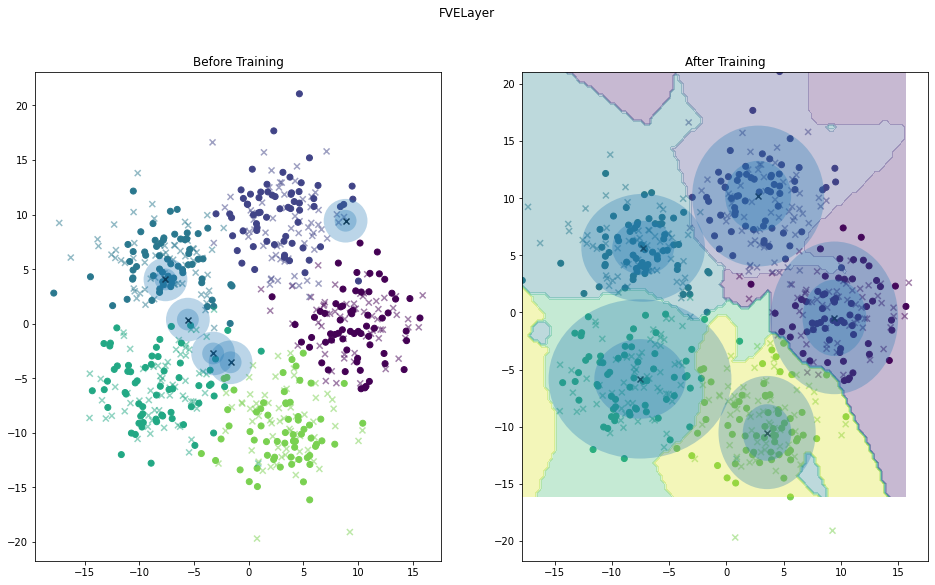

FVEClassifier(
  (fc): Linear(in_size=20, out_size=5, nobias=False),
  (fve_layer): FVELayer_noEM(in_size=2, n_components=5, eps=0.01),
  (post_fve): Linear(in_size=20, out_size=20, nobias=False),
)


epoch       main/accu   main/loss   main/dist   val/main/accu  val/main/loss  val/main/dist
400         0.988633    0.0982256   4.65288     0.94375        1.0983         4.51362        
800         1           0.000525916  4.72287     0.940625       1.29816        4.5854         
1200        1           0.000144088  4.77812     0.94375        1.40177        4.62507        
1600        1           6.63047e-05  4.81342     0.940625       1.48179        4.65377        
2000        1           3.68517e-05  4.84042     0.940625       1.53093        4.67645        


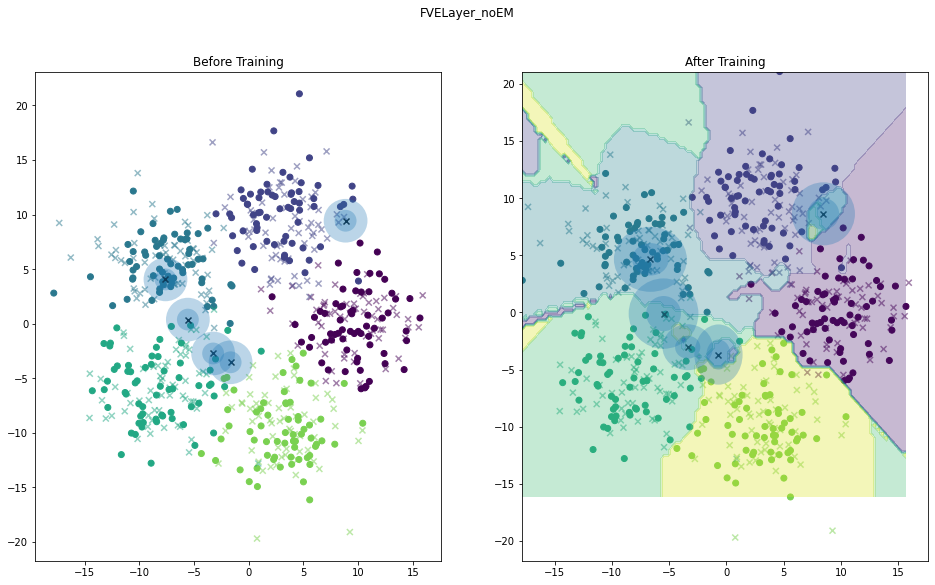

In [49]:
clfs = []

iters_per_epoch = int(args.n_samples*args.n_classes / args.batch_size)

default_epochs = 100
for fve_class, epochs in [(FVELayer, None), (FVELayer_noEM, 2000)]:
    epochs = epochs or default_epochs
    triggers = dict(
        stop=(epochs, "epoch"),
        log=(max(1, int(epochs/5)), "epoch"),
        progress_bar=iters_per_epoch*1
    )

    set_seed(args.seed)
    kwargs = dict(
        fve_class=fve_class,
        init_mu=10, #data._means.T, #data.X.array.mean(axis=0)[:, None],
        init_sig=1, #data._std[0]**2, #data.X.array.var(axis=0)[:, None],
        
    )
        
    clf = FVEClassifier.new(args, **kwargs)
    
    kwargs = dict(
        args=args,
        data=data,
        eval_data=eval_data,
        clf=clf,
        triggers=triggers, 
        plot_decisions=True,
        title=fve_class.__name__
    )

    if 1:
        analyze_classifier(plot_params=True, **kwargs)
    
    else:
        analyze_gradient(plot_norm_grad=True, **kwargs)

    
    clfs.append(clf)
    
#     with chainer.using_config("train", False):
#         feats = clf.encode(data.X)
#         for cls in range(args.n_classes):
#             print(cls)
#             min_feat = feats.array[data.y == cls].min(axis=0).round(3)
#             max_feat = feats.array[data.y == cls].max(axis=0).round(3)
#             print(np.abs(np.sign(min_feat)), np.abs(np.sign(max_feat)), sep="\n")

# Mahalanobis Distances

In [112]:
def _soft_assignment(data, mean, var, w):
    
    n_comps = mean.shape[-1]
    _gmm = GMM(n_components=n_comps, covariance_type="diag", warm_start=True)
    
    _gmm.covariances_ = var.T
    _gmm.precisions_cholesky_ = 1 / np.sqrt(var.T)
    _gmm.means_ = mean.T
    _gmm.weights_ = w
    
    return _gmm.predict_proba(data)

def dist(data, mean, var, w=None):
    print("Input shapes:", data.shape, mean.shape, var.shape)
    _data = data[..., None]
    n_comps = mean.shape[-1]
    _mean = mean[None]
    _var = var[None]
    
    if w is None:
        w = np.ones(n_comps, dtype=_mean.dtype) / n_comps
    
    dist = np.sqrt( ((_data - _mean)**2 / _var).sum(axis=1) )
    gamma = _soft_assignment(data, mean, var, w)
    
    
    return (dist * gamma).sum(axis=-1).mean()

## ... to mean and variance of the Data

In [126]:
_mean = data.X.array.mean(axis=0)[:, None]
_var = data.X.array.var(axis=0)[:, None]
_data = data.X.array
dist(_data, _mean, _var)

Input shapes: (320, 2) (2, 1) (2, 1)


1.3603141

## ... to $\vec\mu$ and $\vec\sigma$ used to generate the Data

In [127]:
_mean = data._means.T
_var = data._std[:, None].repeat(data.n_classes, axis=-1)**2
_data = data.X.array

dist(_data, _mean, _var)

Input shapes: (320, 2) (2, 5) (2, 5)


1.2523237

## ... to $\vec\mu$ and $\vec\sigma$ estimated with a GMM 

In [128]:
_data = data.X.array

gmm = GMM(n_components=data.n_classes, covariance_type="diag")
gmm.fit(_data)

_means = gmm.means_.T
_var = gmm.covariances_.T
_w = gmm.weights_

dist(_data, _means, _var, _w)

Input shapes: (320, 2) (2, 5) (2, 5)


1.2450816757809253

# Entropy and weight distribution

In [51]:
print(f"{-np.log(1/clf.fve_layer.n_components):.5f}")
for clf in clfs:
    w = _get_array(clf.fve_layer.w)
    print(f"{-np.sum(w * np.log(w)): .5f}", w.round(3), w.sum())

1.60944
 1.59926 [0.154 0.195 0.193 0.221 0.236] 1.0000005
 1.59812 [0.235 0.173 0.171 0.182 0.239] 1.0
